In [3]:
import json
from typing import List
import warnings

import geopandas as gpd
import pandas as pd
from scipy.stats import entropy
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler

from TwitterAPI import TwitterAPI

warnings.filterwarnings("ignore")

In [3]:
with open("../config.json") as f:
    config = json.loads(f.read())["Twitter"]

api = TwitterAPI(config["main"])

In [18]:
def process_tweets(df_tweets: pd.DataFrame) -> pd.DataFrame:
    df_tweets["EST"] = pd.to_datetime(df_tweets["created_at"]) - pd.Timedelta(hours=5)
    df_tweets["Date"] = df_tweets["EST"].dt.strftime("%Y%m%d")
    if "geo" in df_tweets.columns:
        df_tweets["PlaceId"] = df_tweets["geo"].apply(lambda x:x["place_id"])
    df_tweets["Text"] = api.parse_tweet(df_tweets["text"])
    df_tweets["Entities"] = df_tweets["entities"]
    df_tweets["Retweet"] = df_tweets["public_metrics"].apply(lambda x: x["retweet_count"])
    df_tweets["Reply"] = df_tweets["public_metrics"].apply(lambda x: x["reply_count"])
    df_tweets["Like"] = df_tweets["public_metrics"].apply(lambda x: x["like_count"])
    df_tweets["Quote"] = df_tweets["public_metrics"].apply(lambda x: x["quote_count"])
    df_tweets["Impression"] = df_tweets["public_metrics"].apply(lambda x: x["impression_count"])
    df_tweets = df_tweets.rename(columns={"author_id": "AuthorId", "id": "Id"})
    columns = [col for col in df_tweets.columns if col[0].upper() == col[0]]
    return df_tweets[columns].set_index(["Date"]).sort_index()

def extract_url(tweet: pd.Series, urls: List[str]):
    if isinstance(tweet["Entities"], dict):
        for url_entity in tweet["Entities"].get("urls", list()):
            url = url_entity["expanded_url"]
            urls.append([url, tweet.name])

### 1. Fetch tweets with geo information

In [ ]:
start_date = "20230203"
end_date = "20230302"
query = "has:geo Derailment"
params = {"geo": "place_id"}
df_tweets_geo = api.search_tweets(query, params=params, start_time=start_date, end_time=end_date) 
df_tweets_geo = df_tweets_geo.dropna(subset=["geo"])
df_tweets_geo = process_tweets(df_tweets_geo)["20230203":"20230228"]
df_tweets_geo.to_pickle("../data/twitter/TweetsGeo.pkl", compression="gzip")

### 2. Fetch all tweets with keywords

In [ ]:
query = "Derailment"

for date in pd.date_range(start_date, end_date, closed="left"):
    start_time = date.strftime("%Y%m%d")
    end_time = (date + pd.Timedelta(1, unit="day")).strftime("%Y%m%d")
    df_tweets = api.search_tweets(query, start_time=start_time, end_time=end_time) 
    for col in ["withheld", "geo"]:
        if col in df_tweets.columns:
            df_tweets = df_tweets.drop(col, axis=1)
    df_tweets = process_tweets(df_tweets)
    df_tweets.to_pickle(f"../data/twitter/pkl/{start_time}.pkl", compression="gzip")

In [ ]:
dfs = list()
for date in pd.date_range(start_date, end_date, closed="left"):
    start_time = date.strftime("%Y%m%d")
    df = pd.read_pickle(f"../data/twitter/pkl/{start_time}.pkl", compression="gzip")
    for col in ["withheld", "geo"]:
        if col in df.columns:
            df = df.drop(col, axis=1)
    dfs.append(df)
df_tweets = pd.concat(dfs)

In [ ]:
df_tweets.to_pickle("../data/twitter/Tweets.pkl", compression="gzip")

### 3. Extract URL

In [ ]:
df_tweets = pd.read_pickle("../data/twitter/Tweets.pkl", compression="gzip")

In [ ]:
urls = list()
df_tweets.apply(lambda x: extract_url(x, urls), axis=1)
df_urls = pd.DataFrame(urls, columns=["URL", "Date"])
df_urls["Count"] = 1
df_urls = df_urls.groupby(["URL", "Date"]).sum().sort_values(["Count"], ascending=False).reset_index()
df_urls["Domain"] = df_urls["URL"].apply(lambda url:"/".join(url.split("/")[:3]))
df_urls = df_urls.set_index(["URL"])

In [ ]:
df_urls.to_csv("../data/twitter/URL.csv", index_label="URL", sep="\t")

### 4. Analysis

In [23]:
df_tweets = pd.read_pickle("../data/twitter/Tweets.pkl", compression="gzip")
df_tweets_url = pd.read_csv("../data/twitter/URL.csv", index_col="URL", sep="\t")
df_tweets_url["Date"] = df_tweets_url["Date"].astype(str)
df_nopolitic_url = df_tweets_url[~df_tweets_url.index.str.contains("trump|biden|politics", regex=True)]
df_domain = df_tweets_url.groupby(["Date", "Domain"])["Count"].sum().reset_index().set_index(["Domain"]).sort_values(["Date", "Count"], ascending=[True, False])
df_nopolitic_domain = df_nopolitic_url.groupby(["Date", "Domain"])["Count"].sum().reset_index().set_index(["Domain"]).sort_values(["Date", "Count"], ascending=[True, False])
date_index = pd.DatetimeIndex(df_tweets.index).drop_duplicates().sort_values()

In [24]:
df_tweets_url

,Date,Count,Domain
URL,,,
https://twitter.com/historyinmemes/status/1626359499693989891/video/1,20230217,13548,https://twitter.com
https://twitter.com/historyinmemes/status/1626359499693989891/video/1,20230216,7327,https://twitter.com
https://www.foxnews.com/politics/biden-admin-turns-down-ohios-request-disaster-assistance-toxic-derailment,20230216,4335,https://www.foxnews.com
https://www.foxnews.com/media/complete-embarrassment-buttigieg-blasted-touting-rail-safety-blaming-trump-ohio-train-derailment,20230216,4286,https://www.foxnews.com
https://twitter.com/GrahamAllen_1/status/1626266592790159360/photo/1,20230216,3598,https://twitter.com
...,...,...,...
https://twitter.com/DaddyDiamonds69/status/1629625661357694977/video/1,20230225,1,https://twitter.com
https://twitter.com/DaddyDiamonds69/status/1629625572115505152/video/1,20230225,1,https://twitter.com
https://twitter.com/DaddyDiamonds69/status/1629625487390568450/video/1,20230225,1,https://twitter.com


#### 4.1 Popularity Analysis

In [25]:
# The most popular media is a pulltion video generated on 02/16/2023
df_tweets_url.groupby(level=0).sum().sort_values(["Count"], ascending=False).head(5)

,Count
URL,
https://twitter.com/historyinmemes/status/1626359499693989891/video/1,23770
https://www.foxnews.com/media/complete-embarrassment-buttigieg-blasted-touting-rail-safety-blaming-trump-ohio-train-derailment,7249
https://www.foxnews.com/politics/biden-admin-turns-down-ohios-request-disaster-assistance-toxic-derailment,6636
https://www.foxnews.com/politics/pete-buttigieg-blames-trump-ohio-train-derailment-were-constrained,5918
https://www.levernews.com/rail-companies-blocked-safety-rules-before-ohio-derailment/,5908


In [26]:
# Most popular domains
domains = df_tweets_url.groupby(["Domain"]).sum().sort_values(["Count"], ascending=False)
domains.head(10)

,Count
Domain,
https://twitter.com,139046
https://www.foxnews.com,31374
https://trib.al,8114
https://www.wkbn.com,7035
https://fxn.ws,7026
https://youtu.be,6911
https://www.levernews.com,6830
http://dlvr.it,6818
https://www.cnn.com,6687


In [27]:
# Most popular non-political media
df_nopolitic_url.groupby(level=0).sum().sort_values(["Count"], ascending=False).head(5)

,Count
URL,
https://twitter.com/historyinmemes/status/1626359499693989891/video/1,23770
https://www.levernews.com/rail-companies-blocked-safety-rules-before-ohio-derailment/,5908
https://www.fastcompany.com/90848025/ohio-train-derailment-toxic-chemicals-pvc-spill-fire-disaster,5778
https://twitter.com/traecrowder/status/1625624908708577281/video/1,4294
https://twitter.com/GrahamAllen_1/status/1626266592790159360/photo/1,4198


In [28]:
# Most popular domains from non-political media
nonpolitic_domains = df_nopolitic_url.groupby(["Domain"]).sum().sort_values(["Count"], ascending=False)
nonpolitic_domains.head(10)

,Count
Domain,
https://twitter.com,138910
https://trib.al,8114
https://fxn.ws,7026
https://youtu.be,6911
https://www.wkbn.com,6849
https://www.levernews.com,6819
http://dlvr.it,6818
https://www.cnn.com,6335
https://www.fastcompany.com,5860


#### 4.2 Time Series Analysis

In [29]:
# Build features
df_features = pd.DataFrame(index=date_index)
tweet_count = df_tweets.groupby(level=0).count()["Text"]
url_count = df_tweets_url.groupby(["Date"]).sum()["Count"]
most_popular_tweet_count = df_tweets_url.loc["https://twitter.com/historyinmemes/status/1626359499693989891/video/1"].set_index(["Date"])["Count"]
popular_domain_count = df_domain[df_domain.index.isin(domains.index[1:25])].groupby(["Date"])["Count"].sum()
popular_nonpolitic_domain_count = df_nopolitic_domain[df_nopolitic_domain.index.isin(nonpolitic_domains.index[1:25])].groupby(["Date"])["Count"].sum()
political_count = df_tweets_url[df_tweets_url.index.str.contains("trump|biden|politics", regex=True)].groupby(["Date"])["Count"].sum()
nonpolitical_count = df_tweets_url[~df_tweets_url.index.str.contains("trump|biden|politics", regex=True)].groupby(["Date"])["Count"].sum()
popular_url = df_tweets_url.groupby(level=0).sum().sort_values(["Count"], ascending=False).index[1:10]
popular_url_count = df_tweets_url[df_tweets_url.index.isin(popular_url)].groupby(["Date"]).sum()["Count"]

url_entropy = list()
nonpolitic_url_entropy = list()
for date in df_tweets.index.drop_duplicates():
    daily_url = df_tweets_url[df_tweets_url["Date"]==date]
    nonpolitic_daily_url = df_nopolitic_url[df_nopolitic_url["Date"]==date]
    url_entropy.append(entropy(daily_url["Count"] / daily_url["Count"].sum()))
    nonpolitic_url_entropy.append(entropy(nonpolitic_daily_url["Count"] / nonpolitic_daily_url["Count"].sum()))
url_entropy = pd.Series(url_entropy, index=date_index)
nonpolitic_url_entropy = pd.Series(nonpolitic_url_entropy, index=date_index)

<AxesSubplot: xlabel='Date'>

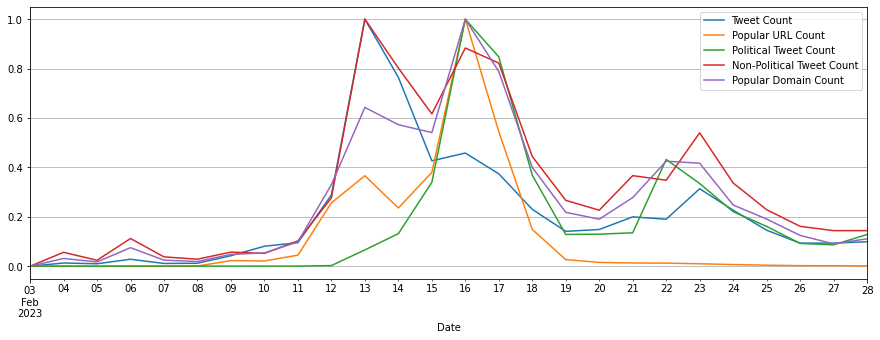

In [30]:
for col, df in [("Tweet Count", tweet_count),
                # ("Most Popular Tweet", most_popular_tweet_count),
                ("Popular URL Count", popular_url_count),
                ("Political Tweet Count", political_count),
                ("Non-Political Tweet Count", nonpolitical_count),
                # ("URL Count", url_count),
                ("Popular Domain Count", popular_domain_count)]:
                # ("Popular Non-Politic Domain", popular_nonpolitic_domain_count)]:
    df.index = pd.DatetimeIndex(df.index)
    df_features[col] = df

df_features = df_features.fillna(0)
df_features = pd.DataFrame(MinMaxScaler().fit_transform(df_features), columns=df_features.columns, index=date_index)
df_features.plot(grid=True, figsize=(15, 5))

In [17]:
df_features.to_csv("../data/twitter/DerailmentFeatures.csv", index_label="Date", sep="\t")

### 4.3 Geo Analysis

In [63]:
df_tweets_geo = pd.read_pickle("../data/twitter/TweetsGeo.pkl", compression="gzip")
df_shp = gpd.read_file("../data/geoshape/cb_2018_us_cbsa_20m/cb_2018_us_cbsa_20m.shp")
df_tweets_place = pd.read_csv("../data/twitter/TwitterPlaceId.csv", sep="\t")

In [75]:
df_geo = df_tweets_geo.merge(df_tweets_place[["Latitude", "Longitude"]], left_on="PlaceId", right_index=True)
geometry = [Point(xy) for xy in zip(df_geo["Longitude"], df_geo["Latitude"])]
df_geo = gpd.GeoDataFrame(df_geo, geometry=geometry, crs="EPSG:4326")
df_geo = gpd.sjoin(df_geo, df_shp, predicate="within", how="left").reset_index().set_index(["Hour"])
df_geo.index = pd.DatetimeIndex(pd.to_datetime(df_geo.index, format="%Y%m%d%H"))

dfs = list()
for hour in df_geo.index.drop_duplicates():
    df = df_geo[df_geo.index==hour]
    gdf = df_shp.set_index(["NAME"])
    gdf["Count"] = df.groupby(["NAME"]).count()["Text"]
    gdf["Count"] = gdf["Count"].fillna(0)
    gdf["Hour"] = hour
    gdf["Date"] = hour.date().strftime("%Y%m%d")
    dfs.append(gdf)

df_geo = pd.concat(dfs).sort_values(["Hour"])

In [74]:
df_geo.to_pickle("../data/twitter/TweetsGeoCount.pkl", compression="gzip")

### 5. Nuclear Leak Analysis

#### 5.1 Fetch tweets

In [7]:
start_date = "20230309"
end_date = "20230401"
query = "Nuclear leak"

for date in pd.date_range(start_date, end_date, closed="left"):
    start_time = date.strftime("%Y%m%d")
    end_time = (date + pd.Timedelta(1, unit="day")).strftime("%Y%m%d")
    df_tweets = api.search_tweets(query, start_time=start_time, end_time=end_time) 
    for col in ["withheld", "geo"]:
        if col in df_tweets.columns:
            df_tweets = df_tweets.drop(col, axis=1)
    df_tweets = process_tweets(df_tweets)
    df_tweets.to_pickle(f"../data/twitter/pkl/{start_time}.pkl", compression="gzip")

In [10]:
dfs = list()
for date in pd.date_range(start_date, end_date, closed="left"):
    start_time = date.strftime("%Y%m%d")
    df = pd.read_pickle(f"../data/twitter/pkl/{start_time}.pkl", compression="gzip")
    for col in ["withheld", "geo"]:
        if col in df.columns:
            df = df.drop(col, axis=1)
    dfs.append(df)
df_tweets = pd.concat(dfs)

In [14]:
df_tweets.to_pickle("../data/twitter/NuclearTweets.pkl", compression="gzip")

#### 5.2 Extract URLs

In [16]:
df_tweets = pd.read_pickle("../data/twitter/NuclearTweets.pkl", compression="gzip")

In [19]:
urls = list()
df_tweets.apply(lambda x: extract_url(x, urls), axis=1)
df_urls = pd.DataFrame(urls, columns=["URL", "Date"])
df_urls["Count"] = 1
df_urls = df_urls.groupby(["URL", "Date"]).sum().sort_values(["Count"], ascending=False).reset_index()
df_urls["Domain"] = df_urls["URL"].apply(lambda url:"/".join(url.split("/")[:3]))
df_urls = df_urls.set_index(["URL"])
df_urls.head(3)

,Date,Count,Domain
URL,,,
https://twitter.com/nypost/status/1636966046966972416/photo/1,20230318,261,https://twitter.com
https://trib.al/qOyDwuj,20230318,261,https://trib.al
https://www.cbsnews.com/news/400000-gallons-radioactive-water-tritium-leak-minnesota-nuclear-plant-xcel-energy/,20230317,248,https://www.cbsnews.com


In [20]:
df_urls.to_csv("../data/twitter/NuclearURL.csv", index_label="URL", sep="\t")

#### 5.3 Popularity Analysis

In [18]:
df_tweets = pd.read_pickle("../data/twitter/NuclearTweets.pkl", compression="gzip")
df_tweets_url = pd.read_csv("../data/twitter/NuclearURL.csv", index_col="URL", sep="\t")
df_tweets_url["Date"] = df_tweets_url["Date"].astype(str)
df_domain = df_tweets_url.groupby(["Date", "Domain"])["Count"].sum().reset_index().set_index(["Domain"]).sort_values(["Date", "Count"], ascending=[True, False])
date_index = pd.DatetimeIndex(df_tweets.index).drop_duplicates().sort_values()

In [19]:
# The most popular one is not related to the leak at all, but all the other ones are, nothing political
df_tweets_url.groupby(level=0).sum().sort_values(["Count"], ascending=False).head(10)

,Count
URL,
https://www.newsweek.com/covid-lab-leak-china-virus-nuclear-war-1787390,357
https://www.cbsnews.com/news/400000-gallons-radioactive-water-tritium-leak-minnesota-nuclear-plant-xcel-energy/,351
https://apnews.com/article/minnesota-xcel-energy-nuclear-radioactive-tritium-leak-c7a12ecb1b203179c5f7fef42bd0a3aa,292
https://trib.al/qOyDwuj,281
https://twitter.com/nypost/status/1636966046966972416/photo/1,281
https://globalnews.ca/news/9559326/nuclear-power-plant-leak-radioactive-water-minnesota/,239
https://www.telegraph.co.uk/world-news/2023/03/17/nuclear-plant-xcel-energy-minneapolis-radioactive-water-leak/,150
https://mol.im/a/11870101,136
https://www.rt.com/news/573108-monticello-nuclear-tritium-leak/,110


In [20]:
# Cbsnewsa adn apnews worth looking into
domains = df_tweets_url.groupby(["Domain"]).sum().sort_values(["Count"], ascending=False)
domains.head(5)

,Count
Domain,
https://twitter.com,957
https://trib.al,543
https://apnews.com,478
https://www.cbsnews.com,473
https://www.newsweek.com,365


In [21]:
# Build features
df_features = pd.DataFrame(index=date_index)
tweet_count = df_tweets.groupby(level=0).count()["Text"]
url_count = df_tweets_url.groupby(["Date"]).sum()["Count"]
popular_domain_count = df_domain[df_domain.index.isin(domains.index[1:6])].groupby(["Date"])["Count"].sum()
popular_url = df_tweets_url.groupby(level=0).sum().sort_values(["Count"], ascending=False).index[1:10]
popular_url_count = df_tweets_url[df_tweets_url.index.isin(popular_url)].groupby(["Date"]).sum()["Count"]


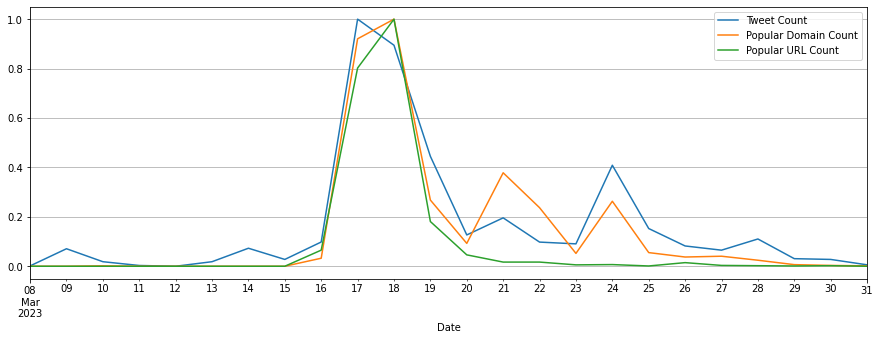

In [22]:
for col, df in [("Tweet Count", tweet_count),
                # ("URL Count", url_count),
                ("Popular Domain Count", popular_domain_count),
                ("Popular URL Count", popular_url_count)]:
    df.index = pd.DatetimeIndex(df.index)
    df_features[col] = df

df_features = df_features.fillna(0)
df_features = pd.DataFrame(MinMaxScaler().fit_transform(df_features), columns=df_features.columns, index=date_index)
df_features.plot(grid=True, figsize=(15, 5))
df_features.to_csv("../data/twitter/NuclearFeatures.csv", index_label="Date", sep="\t")